## Load data

In [1]:
from pathlib import Path
import pandas as pd


usecols = ['food_entity', 'disease_entity', 'sentence', 'is_cause', 'is_treat']
fd_df = pd.read_csv(
    Path('../data/food_disease.csv'),
    sep=',', quotechar='"',
    skipinitialspace=True,
    encoding='utf-8',
    on_bad_lines='skip',
    usecols=usecols).rename({'food_entity': 'term1', 'disease_entity': 'term2'}, axis=1)
fd_df['sentence'] = fd_df['sentence'].map(lambda x: x.lower())
fd_df = fd_df[fd_df.apply(lambda x: x['term1'] in x['sentence'] and x['term2'] in x['sentence'], axis=1)]
label_cols = ['is_cause', 'is_treat']
fd_df['is_cause'] = fd_df['is_cause'].astype(float).astype(int)
fd_df['is_treat'] = fd_df['is_treat'].astype(float).astype(int)

print(len(fd_df))
fd_df.head(3)

595


,term1,term2,sentence,is_cause,is_treat
0,bombax ceiba l. (bombacaceae) fruits,urinary stones,"interestingly, many indian tribes use bombax c...",0,1
1,ultra-processed food,obesity,ultra-processed food consumption has been asso...,1,0
2,salt,osteoporosis,salt has notoriously been blamed for causing a...,1,0


In [2]:
df_cause = pd.read_csv(
    Path('../data/crowd_truth_cause.csv'),
    sep=',', quotechar='"',
    skipinitialspace=True,
    encoding='utf-8',
    on_bad_lines='skip',
    usecols=['sentence', 'term1', 'term2']
)
df_cause['is_cause'] = 1
df_cause['is_treat'] = 0
df_treat = pd.read_csv(
    Path('../data/crowd_truth_treat.csv'),
    sep=',', quotechar='"',
    skipinitialspace=True,
    encoding='utf-8',
    on_bad_lines='skip',
    usecols=['sentence', 'term1', 'term2']
)
df_treat['is_treat'] = 1
df_treat['is_cause'] = 0
ct_df = df_cause.append(df_treat, ignore_index=True)

print(len(ct_df))
ct_df.head(3)

7968


C:\Users\alexs\AppData\Local\Temp\ipykernel_559660\923453060.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ct_df = df_cause.append(df_treat, ignore_index=True)


,term1,term2,sentence,is_cause,is_treat
0,AUTISM,TANTRUM,"The limited data suggest that, in children wit...",1,0
1,SLEEP PROBLEM,FAMILY STRESS,SLEEP PROBLEMs are associated with difficult b...,1,0
2,CEREBELLAR ATAXIA,DYSFUNCTION OF THE CEREBELLUM,The term CEREBELLAR ATAXIA is employed to indi...,1,0


In [3]:
fd_df['source'] = 'FoodDisease'
ct_df['source'] = 'CrowdTruth'
df = pd.concat([fd_df, ct_df])

term1 = 'term1'
term2 = 'term2'

df['prp_sent'] = df['sentence']
df['prp_sent'] = df.apply(lambda x: x['prp_sent'].replace(x['term1'], term1), axis=1)
df['prp_sent'] = df.apply(lambda x: x['prp_sent'].replace(x['term2'], term2), axis=1)
df = df[df['prp_sent'].apply(lambda x: term1 in x and term2 in x)]

print(len(df))
df.head(3)

8416


,term1,term2,sentence,is_cause,is_treat,source,prp_sent
0,bombax ceiba l. (bombacaceae) fruits,urinary stones,"interestingly, many indian tribes use bombax c...",0,1,FoodDisease,"interestingly, many indian tribes use term1 as..."
1,ultra-processed food,obesity,ultra-processed food consumption has been asso...,1,0,FoodDisease,term1 consumption has been associated with sev...
2,salt,osteoporosis,salt has notoriously been blamed for causing a...,1,0,FoodDisease,term1 has notoriously been blamed for causing ...


In [5]:
# !pip install spacy networkx
import spacy
import networkx as nx


nlp = spacy.load('en_core_web_sm')    
doc = nlp(df['sentence'].iloc[0])

def shortest_dep_path(sentence):
    doc = nlp(sentence)
    edges = []
    for token in doc:
        for child in token.children:
            edges.append((
                '{0}'.format(token.lemma_),
                '{0}'.format(child.lemma_)))
    graph = nx.Graph(edges)
    entity1 = term1
    entity2 = term2
    try:
        return nx.shortest_path(graph, source=entity1, target=entity2)
    except Exception as e:
        return []

df['sdp'] = df['prp_sent'].apply(shortest_dep_path)
df = df[df['sdp'].apply(len) > 0]
df['sdp_joined'] = df['sdp'].apply(lambda x: ' '.join(x))
df.to_csv(Path('../data/milestone3/preprocessed.csv'), sep=';', index=False)

print(len(df))
df.head(3)

7978


,term1,term2,sentence,is_cause,is_treat,source,prp_sent,sdp,sdp_joined
0,bombax ceiba l. (bombacaceae) fruits,urinary stones,"interestingly, many indian tribes use bombax c...",0,1,FoodDisease,"interestingly, many indian tribes use term1 as...","[term1, use, as, medicine, for, treatment, of,...",term1 use as medicine for treatment of term2
1,ultra-processed food,obesity,ultra-processed food consumption has been asso...,1,0,FoodDisease,term1 consumption has been associated with sev...,"[term1, consumption, associate, with, outcome,...",term1 consumption associate with outcome as term2
2,salt,osteoporosis,salt has notoriously been blamed for causing a...,1,0,FoodDisease,term1 has notoriously been blamed for causing ...,"[term1, blame, for, term2]",term1 blame for term2


In [2]:
from pathlib import Path
import pandas as pd


df = pd.read_csv(Path('../data/milestone3/preprocessed.csv'), sep=';')
print(len(df))
df.head(3)

7978


,term1,term2,sentence,is_cause,is_treat,source,prp_sent,sdp,sdp_joined
0,bombax ceiba l. (bombacaceae) fruits,urinary stones,"interestingly, many indian tribes use bombax c...",0,1,FoodDisease,"interestingly, many indian tribes use term1 as...","['term1', 'use', 'as', 'medicine', 'for', 'tre...",term1 use as medicine for treatment of term2
1,ultra-processed food,obesity,ultra-processed food consumption has been asso...,1,0,FoodDisease,term1 consumption has been associated with sev...,"['term1', 'consumption', 'associate', 'with', ...",term1 consumption associate with outcome as term2
2,salt,osteoporosis,salt has notoriously been blamed for causing a...,1,0,FoodDisease,term1 has notoriously been blamed for causing ...,"['term1', 'blame', 'for', 'term2']",term1 blame for term2


## BERT features with traditional classifier

In [6]:
# !pip install transformers evaluate datasets
from transformers import AutoTokenizer, AutoModel, pipeline


# Use bert embeddings as features for SVC
# Here using shortest dep path makes sense because it gives context between the 2 entities in question

# https://github.com/EmilyAlsentzer/clinicalBERT
tokenizer = AutoTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
model = AutoModel.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
pipe = pipeline('feature-extraction', model=model, tokenizer=tokenizer, binary_output=True)

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
from pathlib import Path
from tqdm.auto import tqdm
import joblib
import pandas as pd


# Calculate embeddings (takes long and files are GB size)

# sent_embeddings = pipe(list(df['prp_sent']))
# sdp_embeddings = pipe(list(df['sdp_joined']))

# joblib.dump(Path('../data/milestone3/sent_embeddings.pkl'), sent_embeddings)
# joblib.dump(Path('../data/milestone3/sdp_embeddings.pkl'), sdp_embeddings)

In [3]:
import joblib
from pathlib import Path
import numpy as np


sent_embeddings = joblib.load(Path('../data/milestone3/sent_embeddings.pkl'))
# print(len(sent_embeddings), len(sdp_embeddings[0]), len(sdp_embeddings[0][0]), len(sdp_embeddings[0][0][0]))
sent_embeddings = np.array([x[0][0] for x in sent_embeddings]) # CLS embeddings

In [4]:
sdp_embeddings = joblib.load(Path('../data/milestone3/sdp_embeddings.pkl'))
# print(len(sdp_embeddings), len(sdp_embeddings[0]), len(sdp_embeddings[0][0]), len(sdp_embeddings[0][0][0]))
sdp_embeddings = np.array([x[0][0] for x in sdp_embeddings]) # CLS embeddings

In [5]:
sdp_features = pd.DataFrame(sdp_embeddings).to_csv(Path('../data/milestone3/sdp_features.csv'))
sent_features = pd.DataFrame(sent_embeddings).to_csv(Path('../data/milestone3/sent_features.csv'))

In [6]:
import pandas as pd


sdp_features = pd.read_csv(Path('../data/milestone3/sdp_features.csv'))
sent_features = pd.read_csv(Path('../data/milestone3/sent_features.csv'))

labels = df[['is_cause', 'is_treat']]

### Train SDP

In [74]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import confusion_matrix, make_scorer


np.random.seed(1)

X_train, X_test, y_train, y_test = train_test_split(sdp_features, labels, test_size=0.20, shuffle=True, random_state=1)

param_grid = {
    'svc__estimator__C': [0.1, 1, 10]
}

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', MultiOutputClassifier(LinearSVC()))
])

gscv = GridSearchCV(
    pipe, param_grid,
    cv=KFold(n_splits=5, shuffle=True, random_state=1), n_jobs=12, verbose=3
)

gscv.fit(X_train, y_train)
gscv.score(X_test, y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


0.8370927318295739

In [75]:
joblib.dump(gscv, Path('../data/milestone3/gscv_sdp.pkl'), compress=5)

print("Best parameters:", gscv.best_params_)
print("Best score:", gscv.best_score_)

Best parameters: {'svc__estimator__C': 0.1}
Best score: 0.8205918308732014


In [76]:
#!pip install seaborn
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


pred_test = model.predict(X_test)

print(f"accuracy: {accuracy_score(y_test, pred_test)}")

accuracy: 0.8370927318295739


In [77]:
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')


print('Test set (SDP)')
print(classification_report(y_test, pred_test, target_names=['is_cause', 'is_treat']))

Test set (SDP)
              precision    recall  f1-score   support

    is_cause       0.85      0.86      0.86       770
    is_treat       0.87      0.88      0.87       798

   micro avg       0.86      0.87      0.87      1568
   macro avg       0.86      0.87      0.87      1568
weighted avg       0.86      0.87      0.87      1568
 samples avg       0.85      0.85      0.85      1568



accuracy: 0.8621553884711779


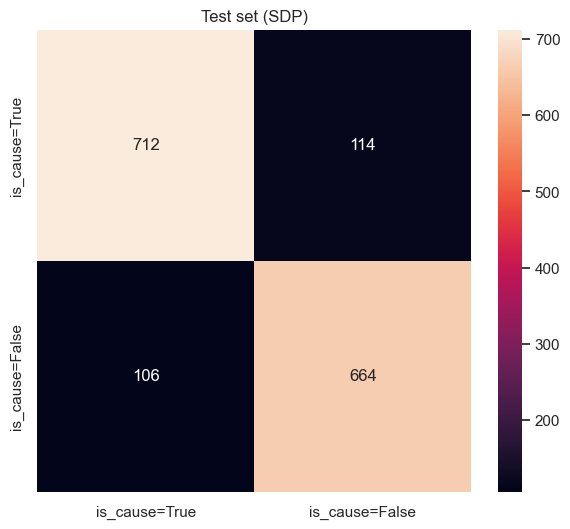

In [78]:
def evaluate_class(y, pred, class_name, title):
    print(f"accuracy: {accuracy_score(y, pred)}")
    
    conf_mat = confusion_matrix(y, pred)
    tick_labels = [f'{class_name}=True', f'{class_name}=False']
    sns.set(rc={'figure.figsize':(7, 6)})
    sns.heatmap(conf_mat, xticklabels=tick_labels, yticklabels=tick_labels, annot=True, fmt='.3g'
        ).set(title=title)


evaluate_class(y_test.values[:, 0], pred_test[:, 0], 'is_cause', 'Test set (SDP)')

accuracy: 0.8715538847117794


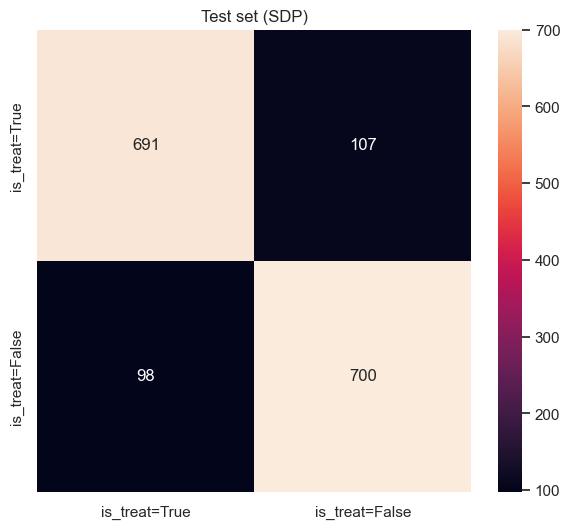

In [79]:
evaluate_class(y_test.values[:, 1], pred_test[:, 1], 'is_treat', 'Test set (SDP)')

### Train full sentence

In [80]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import confusion_matrix, make_scorer


np.random.seed(1)

X_train, X_test, y_train, y_test = train_test_split(sent_features, labels, test_size=0.20, shuffle=True, random_state=1)

param_grid = {
    'svc__estimator__C': [0.1, 1, 10]
}

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', MultiOutputClassifier(LinearSVC()))
])

gscv = GridSearchCV(
    pipe, param_grid,
    cv=KFold(n_splits=5, shuffle=True, random_state=1), n_jobs=12, verbose=3
)

gscv.fit(X_train, y_train)
gscv.score(X_test, y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


0.8264411027568922

In [81]:
joblib.dump(gscv, Path('../data/milestone3/gscv_sent.pkl'), compress=5)

print("Best parameters:", gscv.best_params_)
print("Best score:", gscv.best_score_)

Best parameters: {'svc__estimator__C': 0.1}
Best score: 0.8351615144232539


In [86]:
#!pip install seaborn
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


pred_test = gscv.predict(X_test)

print(f"accuracy: {accuracy_score(y_test, pred_test)}")


accuracy: 0.8264411027568922


In [83]:
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')


print('Test set (full sentence)')
print(classification_report(y_test, pred_test, target_names=['is_cause', 'is_treat']))

Test set (full sentence)
              precision    recall  f1-score   support

    is_cause       0.86      0.86      0.86       770
    is_treat       0.88      0.88      0.88       798

   micro avg       0.87      0.87      0.87      1568
   macro avg       0.87      0.87      0.87      1568
weighted avg       0.87      0.87      0.87      1568
 samples avg       0.84      0.85      0.84      1568



accuracy: 0.8621553884711779


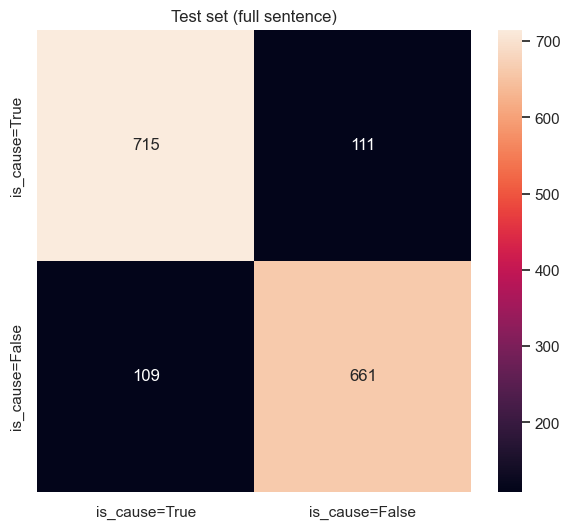

In [84]:
evaluate_class(y_test.values[:, 0], pred_test[:, 0], 'is_cause', 'Test set (full sentence)')

accuracy: 0.881578947368421


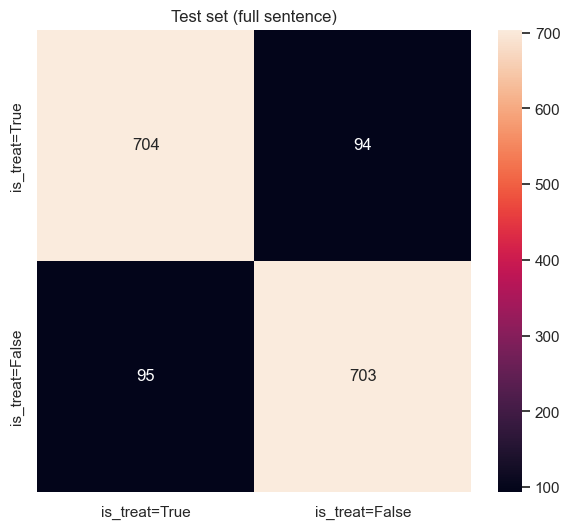

In [85]:
evaluate_class(y_test.values[:, 1], pred_test[:, 1], 'is_treat', 'Test set (full sentence)')

## BERT with classification head

In [ ]:
# https://huggingface.co/docs/transformers/training

from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline
import evaluate
from datasets import Dataset
import numpy as np

dataset = Dataset.from_pandas(df)
dataset

# TODO fix training pipeling (check compute_metrics, check dataset)
model = AutoModelForSequenceClassification.from_pretrained(
    'emilyalsentzer/Bio_ClinicalBERT',
    num_labels=2, problem_type='multi_label_classification'
)
tokenizer = AutoTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
pipe = pipeline('text-classification', model=model, tokenizer=tokenizer)

training_args = TrainingArguments(output_dir='test_trainer', evaluation_strategy='epoch')
metric = evaluate.load('accuracy')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    eval_dataset=dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

loading configuration file config.json from cache at C:\Users\alexs/.cache\huggingface\hub\models--emilyalsentzer--Bio_ClinicalBERT\snapshots\41943bf7f983007123c758373c5246305cc536ec\config.json
Model config BertConfig {
  "_name_or_path": "emilyalsentzer/Bio_ClinicalBERT",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "multi_label_classification",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file pytorch_model.bin from cache at C:\Users\alexs/.cache\huggingface\hub\models--emilyalsentzer--Bio_ClinicalBERT\snapshots\41943bf7f983007123c7583

IndexError: Invalid key: 374 is out of bounds for size 0